## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

This project, is done under the 'Data Analyst Nanodegree' program to help understand the results of an A/B test run by an e-commerce website.  The goal is to write this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
### Read in the dataset and take a look at the top few rows
df  = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
### Number of rows in the dataset.
df.shape[0]

294478

In [4]:
### Number of unique users in the dataset.
df.user_id.nunique()

290584

In [5]:
### Proportion of users converted.
df.query('converted == 1').user_id.nunique() / df.user_id.nunique()

0.12104245244060237

In [6]:
### Number of times the new_page and treatment don't line up.
df.query('(group == "treatment" & landing_page != "new_page") or (group != "treatment" & landing_page == "new_page")').shape[0]

3893

In [7]:
### Rows having missing values
df.isnull().values.any()

False

In [8]:
### Create a new dataset df2 wiht desired rows
df2 = df.drop(df.query('(group == "treatment" & landing_page != "new_page") or (group != "treatment" & landing_page == "new_page")').index)

In [9]:
### Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
### Number of unique user_ids in df2
df2.user_id.nunique()

290584

In [11]:
### user_id repeated in df2
df2[df2.duplicated('user_id') == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [12]:
### row information for the repeat user_id
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
### Remove one of the rows with a repeated user_id
df2= df2.drop_duplicates("user_id")
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


In [14]:
### Calculating conversion probability regardless the page an individual receives
df2.converted.mean()

0.11959708724499628

In [15]:
### Calculating conversion probability in 'control' group
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

In [16]:
### Calculating conversion probability in 'treatment' group
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

In [17]:
### Calculating probability for in individual to receive new page
df2.query('landing_page == "new_page"').user_id.count() / df2.shape[0]

0.5000619442226688

### Considering above results, is there sufficient evidence to conclude that the new treatment page leads to more conversions?

The probability (**0.1188**) of an individual converting when in **treatment** group is almost equal to probability (**0.120**) of an individual converting when in **control** group. In addition, the probability (**0.1196**) of an individual converting regardless of the page they receive is almost equal to the two other mentionned probabilities. Thus we can say that 'there is **NO** sufficient evidence to say that the new treatment page leads to more conversions'.

<a id='ab_test'></a>
### Part II - A/B Test

For now, consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be?  State hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

#### Hypothesis:
$$H_0: p_{new} - p_{old} \leq 0$$ 


$$H_1: p_{new} - p_{old} > 0$$

In [18]:
### Conversion rate for users receiving new page
p_new = df2.query('converted == 1')['user_id'].nunique() / df2['user_id'].nunique()
p_new

0.11959708724499628

In [19]:
### Conversion rate for users receiving old page
p_old = df2.query('converted == 1')['user_id'].nunique() / df2['user_id'].nunique()
p_old

0.11959708724499628

In [20]:
### Number of users in 'treatement' group
n_new = df2.query('landing_page == "new_page"')['user_id'].count()
n_new

145310

In [21]:
### Number of users in 'control' group
n_old = df2.query('landing_page == "old_page"')['user_id'].count()
n_old

145274

In [57]:
### Simulating  n_new  transactions with a converting rate of  p_new  under the null
new_page_converted = np.random.binomial(n_new,p_new)
new_page_converted

17434

In [58]:
### Simulating  n_old  transactions with a converting rate of  p_old  under the null
old_page_converted = np.random.binomial(n_old,p_old)
old_page_converted

17225

In [59]:
### Calculating difference of means of simulated transactions
new_page_converted/n_new - old_page_converted/n_old

0.0014089292838899842

In [60]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new,p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    diff = new_page_converted/n_new - old_page_converted/n_old
    p_diffs.append(diff)

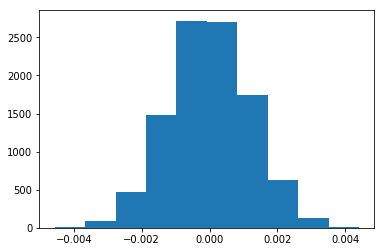

In [61]:
plt.hist(p_diffs);

In [62]:
### Number of users converting given the page they receive
new_converted = df2.query('converted == 1 and landing_page == "new_page"')['user_id'].nunique()
print(new_converted)
old_converted = df2.query('converted == 1 and landing_page == "old_page"')['user_id'].nunique()
print(old_converted)

17264
17489


In [67]:
### Actual converting rates
actual_new_converted = new_converted / n_new 
print(actual_new_converted)
actual_old_converted = old_converted / n_old
print(actual_old_converted)

0.11880806551510564
0.1203863045004612


In [68]:
### Observed difference in converting rate 
observed_diff = actual_new_converted - actual_old_converted
observed_diff

-0.0015782389853555567

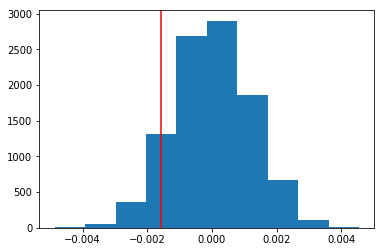

In [70]:
### Generating the Nulls distribution and compare it with the observed difference
p_diffs = np.array(p_diffs);
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(null_vals)
plt.axvline(x=observed_diff,color ='red');

#### Conclusion:

> <span style="color:navy">The calculated p-value is the proportion of conversion differences between new and old pages which is larger than the observed difference in the dataset is alsmost **0.91**. We are give a threshold of Type I error rate of 5%. The calculated p_value is greater than the given threshold. This large p_value suggests that we should not move away from the null hupothesis. In this case, it suggests that we should stay with the old page. Thus we say that we **fail to reject the null hupothesis**.</span>  

> <span style="color:navy">The probability of an individual converting regardless of the page they receive is 11.96%. The probability of an individual converting given they receive old page is 12.04%. The probability of an individual converting given they receive new page is 11.88%.</span>  

> <span style="color:navy">The conversion probablity of users landing on either page (new or old) is almost similar to each other and it is almost equal to that of an individual converting regardless of the page they receive.  
Therefore, there is no evidence that new page gives more conversions. Meaning that new page is **not** any better than the old one.</span>